In [1]:
# 1. 사용할 패키지 불러오기(keras, numpy)
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.


In [2]:
# 랜덤시드 고정시키기
np.random.seed(5)

In [3]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [4]:
# 데이터셋 생성 함수        
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([note2idx[item] for item in subset])
    return np.array(dataset)

In [5]:
# 2. 데이터 준비하기(note, iendex)

# 음계 및 인덱스 사전 정의

note2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2note = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

In [6]:
# 3. 데이터셋 생성하기
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]
one hot encoding vector size is  12


In [7]:
# 4. 모델 구성하기
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [8]:
# 5. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

In [9]:
# 6. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])

Epoch 1/2000
 - 2s - loss: 2.4744 - acc: 0.1600
Epoch 2/2000
 - 0s - loss: 2.3733 - acc: 0.3400
Epoch 3/2000
 - 0s - loss: 2.2874 - acc: 0.3400
Epoch 4/2000
 - 0s - loss: 2.2076 - acc: 0.3400
Epoch 5/2000
 - 0s - loss: 2.1260 - acc: 0.3400
Epoch 6/2000
 - 0s - loss: 2.0629 - acc: 0.3400
Epoch 7/2000
 - 0s - loss: 1.9968 - acc: 0.3400
Epoch 8/2000
 - 0s - loss: 1.9607 - acc: 0.3400
Epoch 9/2000
 - 0s - loss: 1.9288 - acc: 0.3400
Epoch 10/2000
 - 0s - loss: 1.9102 - acc: 0.3400
Epoch 11/2000
 - 0s - loss: 1.8914 - acc: 0.3400
Epoch 12/2000
 - 0s - loss: 1.8799 - acc: 0.3400
Epoch 13/2000
 - 0s - loss: 1.8622 - acc: 0.3400
Epoch 14/2000
 - 0s - loss: 1.8470 - acc: 0.3400
Epoch 15/2000
 - 0s - loss: 1.8317 - acc: 0.3400
Epoch 16/2000
 - 0s - loss: 1.8209 - acc: 0.3400
Epoch 17/2000
 - 0s - loss: 1.8100 - acc: 0.3400
Epoch 18/2000
 - 0s - loss: 1.7982 - acc: 0.3400
Epoch 19/2000
 - 0s - loss: 1.7856 - acc: 0.3400
Epoch 20/2000
 - 0s - loss: 1.7793 - acc: 0.3400
Epoch 21/2000
 - 0s - loss: 1

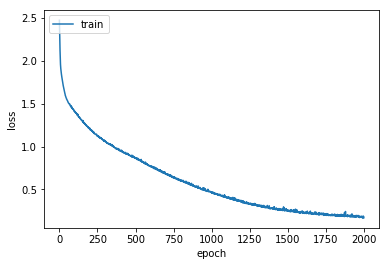

In [10]:
# 7. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [11]:
# 8. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

50/50 [==============================] - 0s 1ms/step
acc: 92.00%


In [12]:
# 9. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측
seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2note[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

# 결과를 저장할 변수 선언
note_onestep = seq_out

# 곡 전체 예측
seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [note2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2note[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

# 결과를 저장할 변수 선언
note_fullsong = seq_out

In [13]:
# 결과 출력
print("one step prediction : ", note_onestep)
print("full song prediction : ", note_fullsong)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd8', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8']


In [17]:
import music21 as m21
from writeMIDI import writeMIDI

def note2midi(notes, num):    # input : seq_out
    n = []
    global start
    start = 0    # 맨 첫 note의 시작 위치
    for i in range(len(notes)):
        #print(notes[i][0], notes[i][1])
        timing = int(8/int(notes[i][1]))
        
        if timing == 1: n.append((notes[i][0]+'5',start+i,1,120))
        else :
            n.append((notes[i][0]+'5',start+i,1*timing,120))
            start += 1
        
        # Output MIDI (Root, Inst., BPM, Notes, File_name)
        writeMIDI('C','piano', 130, n, ('MLP_result_%d' % num))
        
    return print("MLP result_%d export complete!" % num)


note2midi(note_onestep, 1)
note2midi(note_fullsong, 2)

MLP result_1 export complete!
MLP result_2 export complete!
